In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

import keras.backend as K
from keras.models import load_model

C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# YOLO

In [12]:
grid_w = 7
grid_h = 3

def load_photos(directory):
    images = []
    presences = []
    x_labels_loc = []
    y_labels_loc = []
    class_labels_loc = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        images.append(image)
        # get labels
        presences.append(int(name.split('_')[1]))
        x_labels_loc.append(int(float(name.split('_')[2]) * grid_w))
        y_labels_loc.append(int(float(name.split('_')[3].split('.png')[0]) * grid_h))
    return images, presences, x_labels_loc, y_labels_loc

In [13]:
dataset = "Yolo_Datas/"

# load images from both train and test groups
directory = dataset + 'Val'
images, presences, x_labels_loc, y_labels_loc = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)

Loaded Images and labels for training: 295


In [14]:
#Normalise images
images = np.array(images)
images = images
images /= 255.0

In [15]:
model = load_model("../model_YOLO.h5")

# Common

In [16]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[2]
    imshape = imgs.shape[:2]
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:, :, i]
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around plt.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

def layer_to_visualize(layer, img):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    C1 = convout1_f(np.expand_dims(img, axis=0))
    C1 = np.squeeze(C1)
    print("C1 shape : ", C1.shape)

    plt.figure(figsize=(15, 15))
    nice_imshow(plt.gca(), make_mosaic(C1, 4, 4), cmap=cm.binary)

0 <keras.engine.topology.InputLayer object at 0x00000259959904E0>
C1 shape :  (240, 320, 3)
1 <keras.layers.convolutional.Conv2D object at 0x0000025995990B00>
C1 shape :  (59, 79, 16)
5 <keras.layers.convolutional.Conv2D object at 0x0000025995904E10>
C1 shape :  (28, 38, 8)
9 <keras.layers.convolutional.Conv2D object at 0x00000259959A99B0>
C1 shape :  (27, 37, 4)


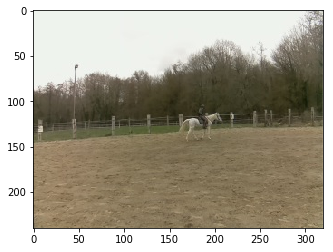

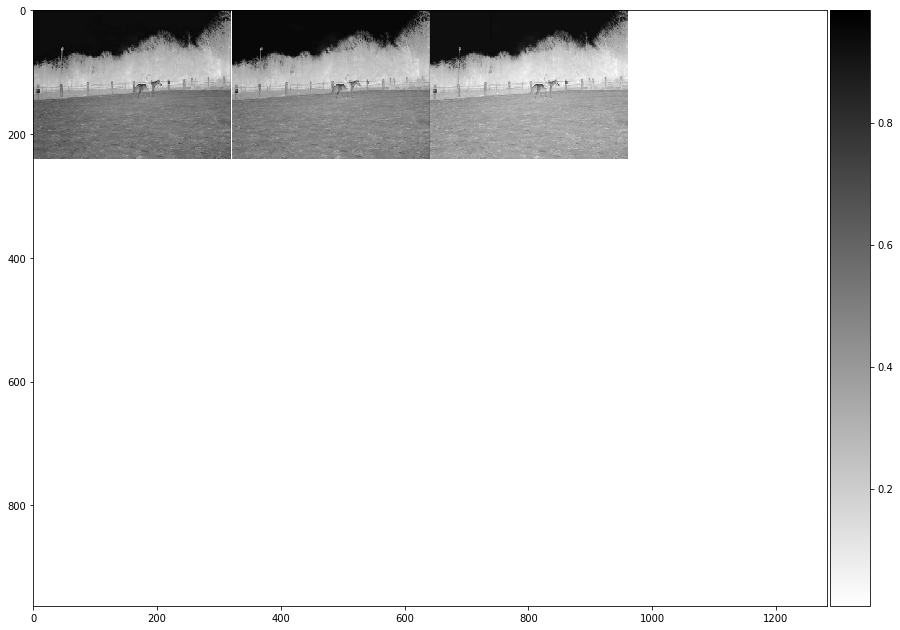

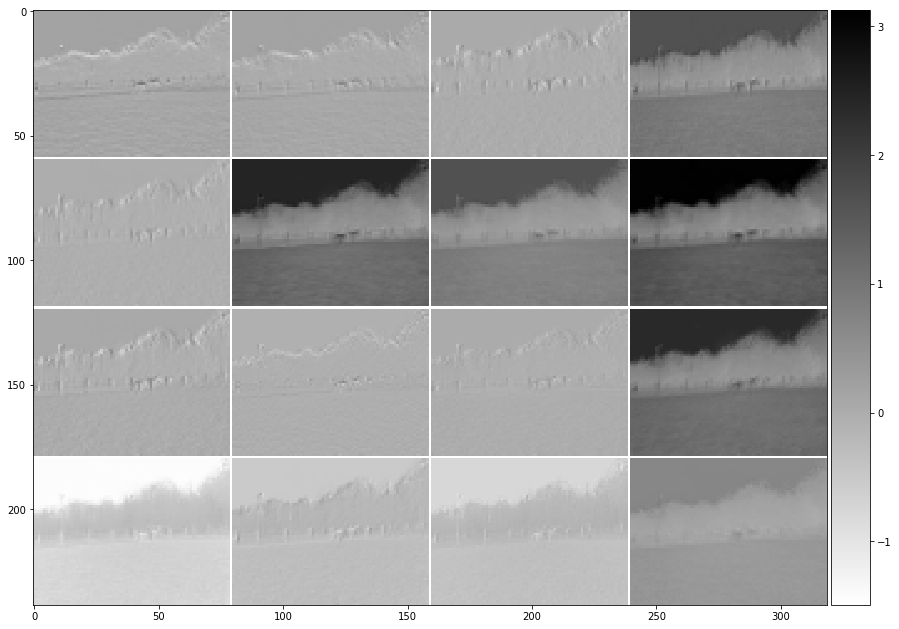

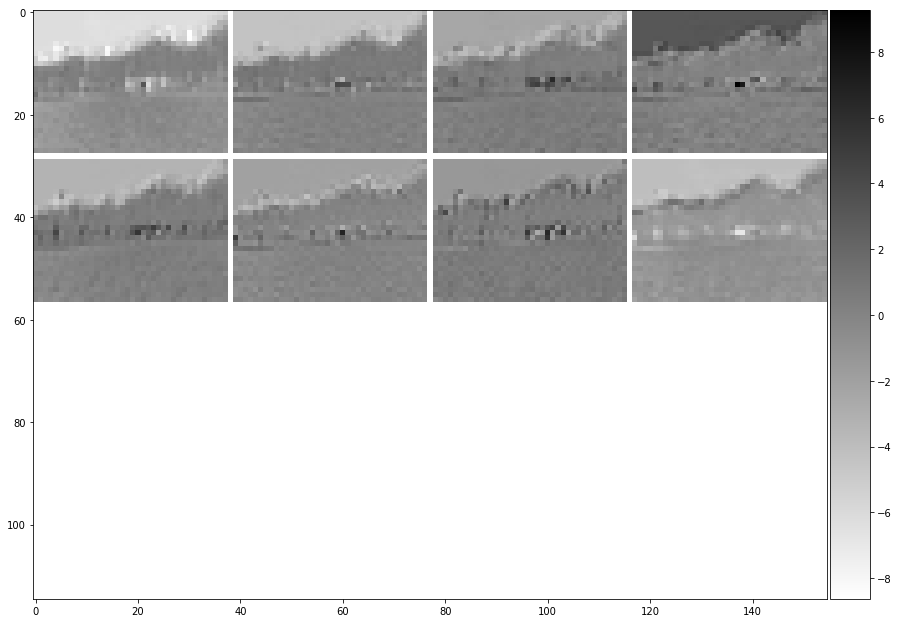

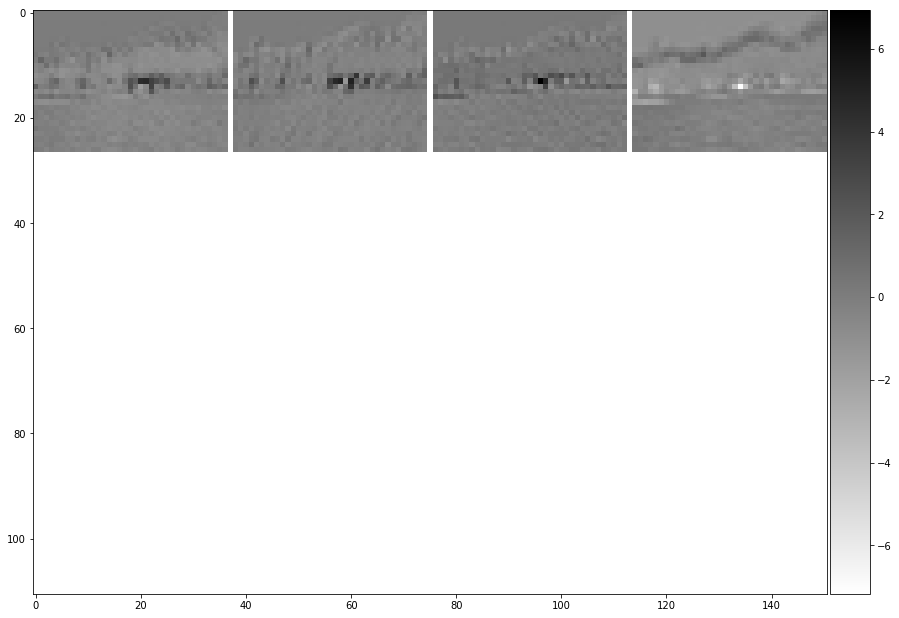

In [17]:
# Specify the image idx and the layer you want to visualize
idx = 42
img_to_visualize = images[idx]

plt.imshow(np.squeeze(img_to_visualize), cmap='gray')

for idx,layer in enumerate(model.layers):
    if 'conv2d' in layer.get_config()['name'] or idx == 0:
        print(str(idx), layer)
        layer_to_visualize(layer, img_to_visualize)